In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from statistics import mean, stdev
import seaborn as sns
from itertools import chain
import math
import re
import nltk
nltk.download('words')
from nltk.corpus import words
from fuzzywuzzy import fuzz
import time

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\202679\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
c:\Handelsdaten_Code\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Data Extraction

In [2]:
column_translations = {'海关编码': 'HS_Code', 
                       '详细产品名称': 'Detailed_Description',
                       '日期': 'Date',
                       '印度进口商': 'Indian_Importer',
                       '数量单位': 'Quantity_Units',
                       '数量': 'Quantity',
                       '美元总金额': 'Total_Dollar_Amount',
                       '美元单价': 'USD_Unit_Price',
                       '卢比总金额': 'Total_Rupees_Amount',
                       '卢比单价': 'Rupees_Unit_Price',
                       '成交外币金额': 'Trans_Amount_Foreign_Currency',
                       '成交外币单价': 'Trans_Unit_Price_Foreign_Currency',
                       '币种': 'Currency',
                       '月度': 'Monthly',
                       '国外出口商': 'Foreign_Exporter',
                       '产销洲': 'Export_Continent',
                       '印度目的港': 'Entry_Port',
                       '国外装货港': 'Shipping_Port',
                       '产品描述': 'Product_Description',
                       '卢比总税费': 'Rupees_Total_Taxes',
                       '关单号': 'Customer_Order_Number',
                       '印度港口代码': 'Indian_Port_Code',
                       '运输方式': 'Transport_Method',
                       '报关行': 'Transport_Company',
                       '报关行代码': 'Transport_Company_Code',
                       '进口商地址': 'Importer_Address',
                       '进口商邮编': 'Importer_Zip_Code',
                       '进口商企业编码': 'Importer_Company_Code',
                       '进口商城市': 'Importer_City',
                       '出口商地址': 'Exporter_Address',
                       '合同号': 'Contract_No',
                       '进出口': 'Import_Or_Export'}

use_cols = ["海关编码", '详细产品名称', '日期', '印度进口商', '数量单位', '数量', '美元总金额', '美元单价', '卢比总金额', '卢比单价', '成交外币金额', '成交外币单价', '币种', '国外出口商', '产品描述', '进口商地址']

In [3]:
#Load suplliers with their aliases

suppliers = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt/Daten/Supplier Names India.xlsx", header=2)

suppliers = suppliers.to_dict('list')

def is_nan(value):
    try:
        return math.isnan(value)
    except:
        return False

for key, value_list in suppliers.items():
    suppliers[key] = [value for value in value_list if not is_nan(value)]

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_23592\3500756359.py:3: SyntaxWarning: invalid escape sequence '\D'
  suppliers = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt/Daten/Supplier Names India.xlsx", header=2)


In [4]:
#Load model namings per supplier

models = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten\Model Mapping.xlsx")
models["Model Details"] = models["Model Details"].fillna('').astype(str)
models['Model Family'] = models['Model Family'].astype(str)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_23592\718793704.py:3: SyntaxWarning: invalid escape sequence '\D'
  models = pd.read_excel("K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten\Model Mapping.xlsx")


In [5]:
#Load raw trade data

base_dir = 'K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten/'
subdirs = ['2021', '2022', '2023', '2024']

# Initialize an empty list to store the file paths
filenames = []

# Loop through each subdirectory
for subdir in subdirs:
    # Construct the full path to the subdirectory
    full_path = os.path.join(base_dir, subdir)
    
    # Check if the subdirectory exists
    if os.path.exists(full_path):
        # Loop through each file in the subdirectory
        for filename in os.listdir(full_path):
            # Construct the full path to the file
            file_path = os.path.join(full_path, filename)
            
            # Add the file path to the list
            filenames.append(file_path)

dfs = []

for file in filenames:
    dfs.append(pd.read_excel(os.path.join(base_dir, file), header=7, dtype={"数量": np.int64, '美元总金额': np.int64, '美元单价': np.int64, '卢比总金额': np.int64, '卢比单价': np.int64}, 
                             usecols=use_cols))

raw_data = pd.concat(dfs)
print(raw_data.head())

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\202679\AppData\Local\Temp\ipykernel_23592\505070620.py:3: SyntaxWarning: invalid escape sequence '\D'
  base_dir = 'K:\DESDN\mbd\pm\mpm_pma/00_Projekte\CSMO\Market Assessment\Market APAC\India\Handelsdatenprojekt\Daten/'


       海关编码                                             详细产品名称          日期  \
0  84143000  COMPRESSOR W11316286 TB1110Y WITH ACCESSORIES(...  2021/01/06   
1  84143000  51330740793YK COMPRESSOR EM 65HHR 220-240V/50H...  2021/01/06   
2  84143000             121L1393 COMPRESSOR MODEL HLJ072T4LC6   2021/01/06   
3  84213920  GPS-IMOD-66-SNAP WITH GPS-IMOD-PS WITH ACCESSO...  2021/01/06   
4  84143000  SAMPLE- COMPRESSOR FOR REFRIGERATOR WITH ACCES...  2021/01/06   

                                        印度进口商  数量单位    数量   美元总金额  美元单价  \
0                 WHIRLPOOL OF INDIA LIMITED   NOS   6480  141134    22   
1      WESTERN REFRIGERATION PRIVATE LIMITED   NOS   2760   67289    24   
2         DANFOSS INDUSTRIES PRIVATE LIMITED   NOS    168   33568   200   
3                        AIRCARE ENGINEERING   NOS      1    1907  1907   
4  SAMSUNG INDIA ELECTRONICS PRIVATE LIMITED   PCS     60    4752    79   

      卢比总金额    卢比单价    成交外币金额   成交外币单价    币种  \
0  10319725    1593  141134.0   

## Basic Data Transformation

In [6]:
#Translate column descriptions, drop unnecessary columns

raw_data.rename(columns=column_translations, inplace=True)
raw_data = raw_data.assign(Origin_Country='')

print(raw_data.head(), raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 336222 entries, 0 to 1974
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   HS_Code                            336222 non-null  int64  
 1   Detailed_Description               336219 non-null  object 
 2   Date                               336222 non-null  object 
 3   Indian_Importer                    336158 non-null  object 
 4   Quantity_Units                     336222 non-null  object 
 5   Quantity                           336222 non-null  int64  
 6   Total_Dollar_Amount                336222 non-null  int64  
 7   USD_Unit_Price                     336222 non-null  int64  
 8   Total_Rupees_Amount                336222 non-null  int64  
 9   Rupees_Unit_Price                  336222 non-null  int64  
 10  Trans_Amount_Foreign_Currency      336186 non-null  float64
 11  Trans_Unit_Price_Foreign_Currency  336186 non-

In [7]:
# Convert na values of detailed description into string

raw_data['Detailed_Description'] = raw_data['Detailed_Description'].fillna('').astype(str)

In [8]:
#Convert date strings into datetime objects and sort by date

raw_data['Date'] = pd.to_datetime(raw_data['Date'], format="%Y/%m/%d")
raw_data.sort_values("Date", inplace=True)


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336222 entries, 1114 to 838
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   HS_Code                            336222 non-null  int64         
 1   Detailed_Description               336222 non-null  object        
 2   Date                               336222 non-null  datetime64[ns]
 3   Indian_Importer                    336158 non-null  object        
 4   Quantity_Units                     336222 non-null  object        
 5   Quantity                           336222 non-null  int64         
 6   Total_Dollar_Amount                336222 non-null  int64         
 7   USD_Unit_Price                     336222 non-null  int64         
 8   Total_Rupees_Amount                336222 non-null  int64         
 9   Rupees_Unit_Price                  336222 non-null  int64         
 10  Trans_Amount_Foreign_Curr

In [10]:
#Filter out suppliers which are car companies

raw_data['Foreign_Exporter'] = raw_data['Foreign_Exporter'].astype(str)

raw_data = raw_data[~raw_data['Foreign_Exporter'].str.contains('MERCEDES|DAIMLER|VOLVO|TOYOTA|FORD|HYUNDAI|JAGUAR', case=False, regex=True)]

## Add Total_Euro_Amount 

- Download current conversion rates whenever new Trade Data is downloaded from: https://data.ecb.europa.eu/data/datasets/EXR/EXR.D.USD.EUR.SP00.A
- Rename to USD_EUR.csv

In [11]:
USD_EUR = pd.read_csv(r"K:/DESDN/mbd/pm/mpm_pma/00_Projekte/CSMO/Market Assessment/Market APAC/India/Handelsdatenprojekt/Daten/USD_EUR.csv")

USD_EUR["DATE"] = pd.to_datetime(USD_EUR["DATE"], format=r"%Y-%m-%d")
USD_EUR.sort_values("DATE", inplace=True)

USD_EUR.set_index('DATE', inplace=True)
full_date_range = pd.date_range(start=USD_EUR.index.min(), end=USD_EUR.index.max())
USD_EUR = USD_EUR.reindex(full_date_range)

USD_EUR['US dollar/Euro (EXR.D.USD.EUR.SP00.A)'] = USD_EUR['US dollar/Euro (EXR.D.USD.EUR.SP00.A)'].ffill().bfill()

USD_EUR.reset_index(inplace=True)
USD_EUR.rename(columns={'index': 'DATE'}, inplace=True)

In [12]:
'''
def convert_currency(row, conversion=USD_EUR):
    
    print(type(row))
    print(conversion["DATE"])

    sel = conversion[conversion["DATE"] == row['Date']]
    #sel = conversion.merge(right=row, left_on="DATE", right_on="Date", how="inner")
    exchange_rate = sel.iloc[0]["US dollar/Euro (EXR.D.USD.EUR.SP00.A)"]

    return int(row["Total_Dollar_Amount"] / exchange_rate)

raw_data["Total_Euro_Amount"] = raw_data.apply(lambda x: convert_currency(x), axis=1)
'''

'\ndef convert_currency(row, conversion=USD_EUR):\n    \n    print(type(row))\n    print(conversion["DATE"])\n\n    sel = conversion[conversion["DATE"] == row[\'Date\']]\n    #sel = conversion.merge(right=row, left_on="DATE", right_on="Date", how="inner")\n    exchange_rate = sel.iloc[0]["US dollar/Euro (EXR.D.USD.EUR.SP00.A)"]\n\n    return int(row["Total_Dollar_Amount"] / exchange_rate)\n\nraw_data["Total_Euro_Amount"] = raw_data.apply(lambda x: convert_currency(x), axis=1)\n'

In [13]:
def USD_EUR_Conversion(data, USD_EUR):

    merged_data = data.merge(USD_EUR, left_on='Date', right_on='DATE', how='left')

    # Currency conversion
    merged_data['Total_Euro_Amount'] = merged_data['Total_Dollar_Amount'] / merged_data['US dollar/Euro (EXR.D.USD.EUR.SP00.A)']
    print(merged_data[merged_data['Total_Euro_Amount'].isna()])
    merged_data['Total_Euro_Amount'] = merged_data['Total_Euro_Amount'].astype(int)
    merged_data['Euros_Unit_Price'] = merged_data['USD_Unit_Price'] / merged_data['US dollar/Euro (EXR.D.USD.EUR.SP00.A)']
    merged_data['Euros_Unit_Price'] = merged_data['Euros_Unit_Price'].astype(int)

    # Drop the extra 'DATE' column from the merge if desired
    merged_data.drop(columns=['DATE', 'US dollar/Euro (EXR.D.USD.EUR.SP00.A)'], inplace=True)

    return merged_data

raw_data = USD_EUR_Conversion(raw_data, USD_EUR)

Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, DATE, TIME PERIOD, US dollar/Euro (EXR.D.USD.EUR.SP00.A), Total_Euro_Amount]
Index: []

[0 rows x 21 columns]


In [14]:
raw_data.head()

,HS_Code,Detailed_Description,Date,Indian_Importer,Quantity_Units,Quantity,Total_Dollar_Amount,USD_Unit_Price,Total_Rupees_Amount,Rupees_Unit_Price,Trans_Amount_Foreign_Currency,Trans_Unit_Price_Foreign_Currency,Currency,Foreign_Exporter,Product_Description,Importer_Address,Origin_Country,TIME PERIOD,Total_Euro_Amount,Euros_Unit_Price
0,84143000,"KF571001, COMPRESSOR SUITABLE FOR BOLERO",2021-01-01,MAHLE ANAND THERMAL SYSTEMS PRIVATE LIMITED,NOS,75,3690,49,269813,3598,3690.0,49.20,USD,UNNAYI(NANTONG)SCIEN-TECH CO. LTD.,Compressors for refrigerating equipment,"29,MILESTONE,PUNE-NASIK HIGHWAYKURULI,KHED",,NaN,3007,39
1,84212900,83630716 FUEL FILTER (COMPONENTS FOR CONSTRUCT...,2021-01-01,SCHWING STETTER (INDIA) PRIVATE LIMITED,PCS,15,168,11,12284,819,168.0,11.20,USD,XUZHOU RANRY IMP&EXP CO LTD,Machinery and apparatus for filtering or purif...,"F-71,SIPCOT INDL.PARK,SRIPERUMBUDURTALUK, IRUN...",,NaN,136,8
2,84212900,AF25667 AIR FILTER (C/O MX),2021-01-01,AGROMACH SPARES CORPORATION,NOS,18,477,27,34878,1938,477.0,26.50,USD,ILKERLER ENDUSTRI SATIS VE PAZALAMA A. S.,Machinery and apparatus for filtering or purif...,"JETHALAL MANSION, 3RD FLR.,10 BANK STREET*CROS...",,NaN,388,22
3,84148011,COMPRESSOR (MODEL NO. 1YC32CXD#A6) (MFR/BRAND:...,2021-01-01,DAIKIN AIRCONDITIONING INDIA PVT. LTD.,UNT,384,18140,47,1326397,3454,18140.0,47.24,USD,DAIKIN COMPRESSOR INDUSTRIES LTD.,"Air pumps, air or other gas compressors and ve...","F-25/2, OKHLA INDUSTRIAL AREA,PHASEII,",,NaN,14782,38
4,84212900,FF4052A FUEL FILTER (C/O IN),2021-01-01,AGROMACH SPARES CORPORATION,NOS,3,13,4,950,317,13.0,4.43,USD,ILKERLER ENDUSTRI SATIS VE PAZALAMA A. S.,Machinery and apparatus for filtering or purif...,"JETHALAL MANSION, 3RD FLR.,10 BANK STREET*CROS...",,NaN,10,3


## Exploration

In [15]:
#Exploration to make sense of amounts

sel_set = raw_data[raw_data["Quantity_Units"] == "SET"]

sel_other = raw_data[raw_data["Quantity_Units"] != "SET"]

sel_set = sel_set["Quantity"].to_list()
sel_other = sel_other["Quantity"].to_list()

print("Mean of Set Amounts:", mean(sel_set),
      "\nSdev of Set Amounts:", stdev(sel_set))

print("Mean of Other Amounts:", mean(sel_other),
      "\nSdev of Other Amounts:", stdev(sel_other))

Mean of Set Amounts: 806.6796021122436 
Sdev of Set Amounts: 2372.533357548459
Mean of Other Amounts: 894.6437478660456 
Sdev of Other Amounts: 33767.957146775014


321060


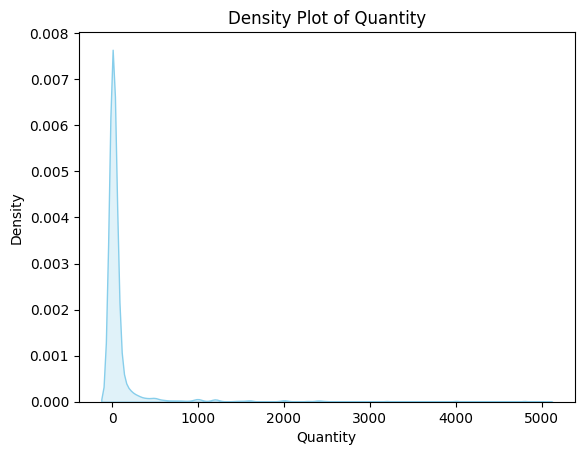

In [16]:
#Exploration to make sense of quantities

sel = raw_data[raw_data['Quantity'] < 5000]
print(len(sel))
sns.kdeplot(sel["Quantity"], fill=True, color='skyblue')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.title('Density Plot of Quantity')
plt.show()

## Drop Deliveries with Quantities <= 0

In [17]:
print("Anzahl Quantaties kleiner gleich 0:",len(raw_data[raw_data["Quantity"] <= 0].index))
print(raw_data[raw_data["Quantity"] <= 0])
raw_data = raw_data.drop(raw_data[raw_data["Quantity"] <= 0].index)

Anzahl Quantaties kleiner gleich 0: 227
         HS_Code                               Detailed_Description  \
1347    84212900  L STRAINER 305 PP-H/EPDM D20DN15 167305300 (2 ...   
3600    84212900  417-02 MOVING J/C STRAINER (S.P FOR DIE CASTIN...   
3666    84212900  417-01 FIXED J/C STRAINER (S.P FOR DIE CASTING...   
5747    84212900  FILTER\HILCO\SIMPLEX\MODEL NO 4960-00-682-C\FL...   
7505    84212900  8162, SPINX FLTR 2ML 45UM CA S BK (CASE1) (QTY...   
...          ...                                                ...   
324118  84212900                     FILTER ELEMENT 0160 R010 P/HC    
324193  84212900                                    FILTER ELEMENT    
324211  84212900                      FILTER ELEMENT 0060 D 020 ON    
324240  84212900                     FILTER ELEMENT 0240 R010 P/HC    
324246  84212900                                    FILTER ELEMENT    

             Date                                Indian_Importer  \
1347   2021-01-10  GEORG FISCHER PIPING

In [18]:
#Convert strings to upper case to make atring matching easier

raw_data ["Indian_Importer"] = raw_data["Indian_Importer"].str.upper()
raw_data ["Foreign_Exporter"] = raw_data["Foreign_Exporter"].str.upper()
raw_data ["Detailed_Description"] = raw_data["Detailed_Description"].str.upper()


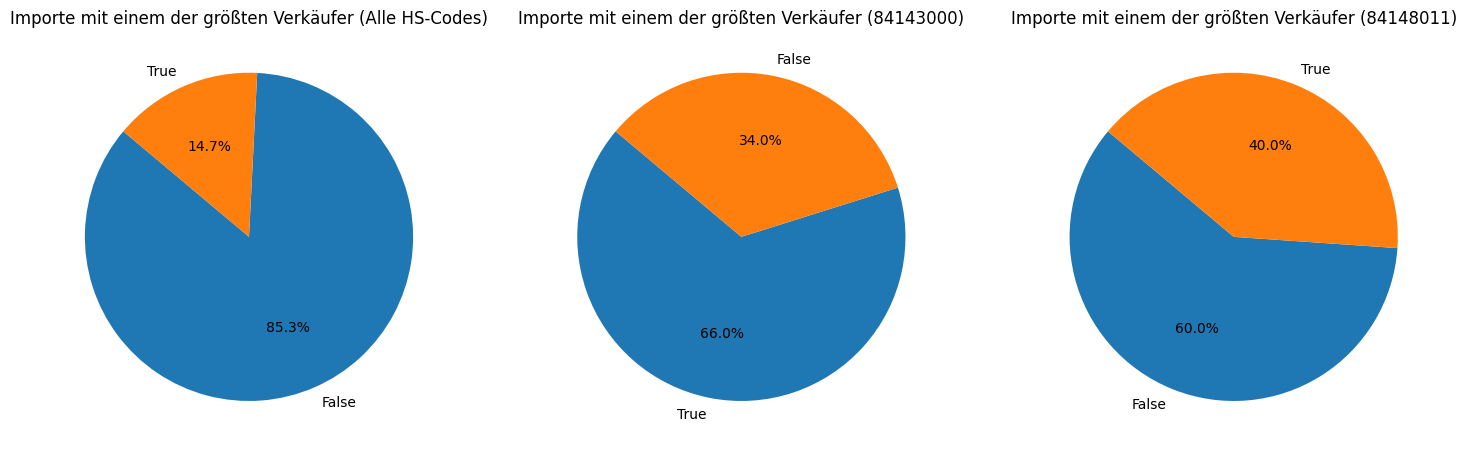

In [19]:
#Explore how many entries are of major competitors

sel1 = raw_data[raw_data['HS_Code'] == 84143000]
sel2 = raw_data[raw_data['HS_Code'] == 84148011]

substrings = ['Bock', 'Danfoss', 'Mayekawa', 'Dorin', 'Fujian', 'SRM', 'Comer', 'Fu Sheng', 'Daikin', 'J&E', 'J & E', 'GEA', 'Frascold', 'Hanbell', 'Snowman', 'Emerson', 'Copeland', 'Bitzer', 'Siam', 'Invotech']
count = raw_data['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)
count1 = sel1['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)
count2 = sel2['Foreign_Exporter'].str.contains('|'.join(substrings), case=False)

# Berechne die Anteile
all_counts = count.value_counts(normalize=True)
hs84143000_counts = count1.value_counts(normalize=True)
hs84148011_counts = count2.value_counts(normalize=True)

# Visualisierung als Kreisdiagramme
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Alle HS-Codes
axs[0].pie(all_counts, labels=all_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Importe mit einem der größten Verkäufer (Alle HS-Codes)')

# HS-Code 84143000
axs[1].pie(hs84143000_counts, labels=hs84143000_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Importe mit einem der größten Verkäufer (84143000)')

# HS-Code 84148011
axs[2].pie(hs84148011_counts, labels=hs84148011_counts.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Importe mit einem der größten Verkäufer (84148011)')

plt.show()

## Categorizations by Main Competitors and (obvious) Compressor Types

In [20]:
#Categorize by main competitors

competitor_mapping = {'Frascold': ['FRASCOLD'], 
                      'MYCOM': ['MAYEKAWA'],
                       'Snowman': ['FUJIAN', 'SRM', 'SNOWMAN'],
                        'Hanbell': ['HANBELL', 'COMER'],
                         'Fu Sheng': ['FU SHENG', 'FUSHENG'],
                           'Daikin': ['DAIKIN'],
                           'J&E Hall': ['J&E', 'J & E'],
                           'GEA': ['GEAREFRIG', 'GEA REFRIG'],
                           'Dorin': ['DORIN'],
                           'Bock': ['BOCK'],
                           'Danfoss': ['DANFOSS'],
                           'Copeland/Emerson': ['EMERSON', 'COPELAND'],
                           'BITZER': ['BITZER'],
                           'Siam': ['SIAM'],
                           'Invotech': ['INVOTECH']}

def map_competitor(exporter, mapping):
        
    if isinstance(exporter, str):
        for competitor, substrings in mapping.items():
            for substring in substrings:
                if substring in exporter:
                    return competitor
    return 'Other'

raw_data['Foreign_Exporter'] = raw_data['Foreign_Exporter'].str.upper()
raw_data["Competitor"] = raw_data['Foreign_Exporter'].apply(map_competitor, args=(competitor_mapping,))

In [21]:
#Categorize compressor types

compressor_mapping = {'Recip': 'RECIP',
                      'Scroll': 'SCROLL',
                      'Screw': 'SCREW',
                      'Rotary': 'ROTARY'}

def map_compressor(description, mapping):
    for type, substring in mapping.items():
        if substring in description:
            return type
    return ''

raw_data['Compressor_Type'] = raw_data['Detailed_Description'].apply(lambda x: map_compressor(x, compressor_mapping))

print(raw_data[['Detailed_Description', 'Compressor_Type']].head(10))

                                Detailed_Description Compressor_Type
0          KF571001, COMPRESSOR SUITABLE FOR BOLERO                 
1  83630716 FUEL FILTER (COMPONENTS FOR CONSTRUCT...                
2                       AF25667 AIR FILTER (C/O MX)                 
3  COMPRESSOR (MODEL NO. 1YC32CXD#A6) (MFR/BRAND:...                
4                      FF4052A FUEL FILTER (C/O IN)                 
5                       AF25957 AIR FILTER (C/O FR)                 
6    OIL SEPARATOR - YFQ-F00101-001- AS PER INVOCIE                 
7                FS36215 FUEL/WATER FILTER (C/O CN)                 
8                       LF3325 LUBE FILTER (C/O MX)                 
9               TBZ35619701 - COMPRESSOR SET, KOREA                 


In [22]:
#Add Bock model mapping and replace numerical model descriptions with letter descriptions

Bock_Mapping = {'14057': ' FEX ',
                '14056': ' FKX ',
                '20250': ' FKX ',
                '20071': ' FKX ',
                '11712': ' F16 ',
                '11702': ' F16 ',
                '11700': ' F16 ',
                '144': ' HG '} #leave empty space before and after so string_matching can identify it as a seperate chunk (word)

for key, value in Bock_Mapping.items():
    raw_data.loc[raw_data['Competitor'] == 'Bock', 'Detailed_Description'] = raw_data.loc[raw_data['Competitor'] == 'Bock', 'Detailed_Description'].str.replace(key, value)

## String Matching of Descriptions to identify models and types

In [23]:
#Function to check if word is (kind of) english

english_words = set(words.words())

def is_english_word(word, threshold=80):
    # Check for exact match
    compressor_keywords = ["Screw", "Compressor", "Comp", "Compresor", "Recip", "Rotary", "Centrifugal"]
    if word in english_words or word in compressor_keywords:
        return True
    
    # Use fuzzy matching to find the closest word
    #closest_match = max(english_words, key=lambda x: fuzz.ratio(word.lower(), x.lower()))
    #match_score = fuzz.ratio(word.lower(), closest_match.lower())
    
    #return match_score >= threshold


In [24]:
print(is_english_word('OPEN_TYPE_COMPRESSOR_V'))

None


In [25]:
# Definition of string matching functions to get the model type and compressor type

def string_match(description, company, mapping=models.copy()):
    '''
    This function scans the detailed description column of the trade data for model descriptions corresponding to the company. Must be applied row-wise
    
    Args:
        description (Iterable): Detailed Description column
        company (Iterable): Company column
        mapping (pandas.DataFrame): Optional, the model mapping per company with comp types. Defaults to models

    Returns:
        Tuple: model, comp_type, comp_family per row as a tuple of strings. Returns "Unknown Model" if model is unknown or "Unknown Company" if company is unknown
               and "" (empty String) for comp_type and "Unknown Family" for comp_family in both cases
    '''
   
    
    model = "Unknown_Model"
    comp_type = ""
    comp_family = "Unknown_Family"

    if company == "Other":
        return "Unknown_Company", comp_type, comp_family
    
    #delimiters = [",", "-", ":", " ", "/", "(", ")", "_", "&", ".", ";", "[", "]"]
    
    #chunks = re.split(r'|'.join(delimiters), description)

    #Workaround since for Bitzer there are models named COMPRESSOR I and so on
    if company != "BITZER":
        chunks = str.split(description)
    else:
        chunks = [description]
    model_sel = mapping[mapping["Company"] == company]

    for chunk in chunks:
        
        #Only model descriptions are interesting
        if is_english_word(chunk):
            continue
        
        
        for index, row in model_sel.iterrows():

            if row["Model Details"] != '':
            
                # Check if both Model Family and Model Details are in chunk
                if row['Model Family'] in chunk and row['Model Details'] in chunk:
                    # Get the positions of Model Family and Model Details
                    family_index = chunk.find(row['Model Family'])
                    details_index = chunk.find(row['Model Details'])
                    
                    
                    # Ensure Model Details appears after Model Family
                    if family_index < details_index:
                        model = f"{row['Model Family']}...{row['Model Details']}"
                        comp_type = row['Compressor Type']
                        comp_family = row['Compressor Family']
            else:
                if row['Model Family'] in chunk:
                    model = row["Model Family"]
                    comp_type = row['Compressor Type']
                    comp_family = row['Compressor Family']
                
    return model, comp_type, comp_family

In [26]:
print(raw_data["Competitor"].unique())

['Other' 'Daikin' 'BITZER' 'Hanbell' 'Copeland/Emerson' 'Danfoss' 'MYCOM'
 'Fu Sheng' 'Siam' 'Invotech' 'Frascold' 'J&E Hall' 'GEA' 'Snowman'
 'Dorin' 'Bock']


In [27]:
def exclude_parts(data, mapping_parts=models.copy()):
    '''
    This function excludes parts according to the model mapping file. For a given company it excludes all records where a parts characters entry is in tthe product description and/or 
    the Eur_Unit_Price is smaller. This function also excludes ALL deliveries from unknown companies which are not specified in Supplier Names. Unique Company Names in models must
    exactly match the unique Competitor Names.

    Args:
        data (pandas.DataFrame): Tradedata to filter
        mapping (pandas.DataFrame): Optional, the model mapping per company with comp types. Defaults to models

    Returns:
        pandas.DataFrame: The filtered Dataframe
    '''

    dfs = []

    #Get unique company names
    companies = mapping_parts["Company"].unique()

    #Drop redundant rows where no Parts Characters AND Min Unit Price aren't specified
    mapping_parts.dropna(subset=["Parts Characters", "Min Unit Price"], how="all", inplace=True)

    #Fill empty cells with dummy values which won't filter
    mapping_parts["Parts Characters"] = mapping_parts["Parts Characters"].fillna("")
    mapping_parts["Min Unit Price"] = mapping_parts["Min Unit Price"].fillna(0)

    print(mapping_parts)

    #
    dfs = []
    for company in companies:
        model_sel = mapping_parts[mapping_parts["Company"] == company]
        filter = model_sel[["Parts Characters", "Min Unit Price"]]
        data_sel = data[data["Competitor"] == company]
        
        for i in filter.index:
            if filter["Parts Characters"][i] == "" and filter["Min Unit Price"][i] == 0: #In this case everything will be filtered out, so skip this filter row
                continue

            elif filter["Parts Characters"][i] != "" and filter["Min Unit Price"][i] != 0:
                print("Both:", company, filter["Parts Characters"][i], filter["Min Unit Price"][i])
                data_sel = data_sel[~((data_sel["Detailed_Description"].str.contains(filter["Parts Characters"][i])) & (data_sel["Euros_Unit_Price"] < filter["Min Unit Price"][i]))]

            elif filter["Parts Characters"][i] == "" and filter["Min Unit Price"][i] != 0:
                print("Price:", company, filter["Min Unit Price"][i])
                data_sel = data_sel[(data_sel["Euros_Unit_Price"] > filter["Min Unit Price"][i])]

            elif filter["Parts Characters"][i] != "" and filter["Min Unit Price"][i] == 0:
                print("Characters:", company, filter["Parts Characters"][i])
                data_sel = data_sel[(~data_sel["Detailed_Description"].str.contains(filter["Parts Characters"][i]))]

        dfs.append(data_sel)

    output = pd.concat(dfs)

    return output
        

In [28]:
test = exclude_parts(raw_data)

              Company Compressor Type Compressor Family  Model Family  \
16             BITZER           Screw         Open-Type           OSN   
17             BITZER           Screw         Open-Type           OSK   
18             BITZER           Screw         Open-Type           OSA   
67               Bock           Recip                SH         EX-HG   
89   Copeland/Emerson     Centrifugal       Centrifugal   CENTRIFUGAL   
212             Dorin           Recip                SH          2S-H   
226          Frascold           Recip                SH             A   
227          Frascold           Recip                SH             A   
310               GEA           Recip         Open-Type  GEA Grasso V   
319           Hanbell     Centrifugal       Centrifugal   CENTRIFUGAL   
320           Hanbell           Screw        SH/Compact          3609   
321           Hanbell           Screw        SH/Compact          3611   
374          J&E Hall           Screw         Open-

In [29]:
print(len(test.index))

41469


In [30]:
print(len(raw_data[raw_data["Competitor"] != "Other"].index))

47588


In [31]:
raw_data = test

In [32]:
print(models)

     Company Compressor Type Compressor Family Model Family  Displacement  \
0     BITZER           Recip         Open-Type          BO3           NaN   
1     BITZER           Recip         Open-Type          BO4           NaN   
2     BITZER           Recip         Open-Type          BO5           NaN   
3     BITZER           Recip         Open-Type          BO6           NaN   
4     BITZER           Recip         Open-Type         BOA3           NaN   
..       ...             ...               ...          ...           ...   
421  Snowman           Screw        SH/Compact          SRH           NaN   
422  Snowman           Screw        SH/Compact          SRM           NaN   
423  Snowman           Screw        SH/Compact          SRS           NaN   
424  Snowman           Screw        SH/Compact         SW3L           NaN   
425  Snowman           Screw        SH/Compact         SW5L           NaN   

     Power Model Details  Coolants Parts Characters  Min Unit Price  
0    

In [33]:
raw_data.loc[raw_data['Competitor'] == 'BITZER', 'Detailed_Description'] = raw_data.loc[raw_data['Competitor'] == 'BITZER', 'Detailed_Description'].str.replace(' ', '_')

In [34]:
raw_data[['models', 'comp_types', 'comp_family']] = raw_data.apply(lambda row: pd.Series(string_match(row["Detailed_Description"], row["Competitor"])), axis=1)

In [35]:
raw_data["comp_family"] = raw_data["comp_family"].fillna("Unknown_Family")

In [36]:
# Merge Comp_Type Columns into comp_types

raw_data['comp_types'] = raw_data['comp_types'] + raw_data['Compressor_Type']


In [37]:

raw_data = raw_data.drop("Compressor_Type", axis=1)

In [38]:

raw_data['comp_types'] = raw_data['comp_types'].replace({
    'RecipRecip': 'Recip',
    'ScrewScrew': 'Screw',
    'ScrollScroll': 'Scroll',
    'ScrollScrew': 'Scroll',
    'RecipScrew': 'Recip',
    'ScrollRecip': 'Scroll',
    'ScrewRecip': 'Screw',
    'ScrewScroll': 'Screw',
    'RecipScroll': 'Recip',
    'RecipRotary': 'Recip',
    'ScrewRotary': 'Screw',
    'ScrollRotary': 'Scroll',
    'Open-typeRecip': 'Open-type',
    'Open-typeScrew': 'Open-type',
    'Open-typeScroll': 'Open-type',
    'ACPScrew': 'ACP',
    'ACPRecip': 'ACP',
    'ACPScroll': 'ACP',
    '': 'Unknown Type',
    ' ': 'Unknown Type'
})

raw_data['comp_types'] = raw_data['comp_types'].fillna('Unknown Type')

print(raw_data[(raw_data['comp_types'] != 'Unknown Type') & (raw_data['comp_types'] != 'Recip') & (raw_data['comp_types'] != 'Screw') & (raw_data['comp_types'] != 'Scroll') & (raw_data['comp_types'] != 'Open-type') & (raw_data['comp_types'] != 'Centrifugal') & (raw_data['comp_types'] != 'Rotary')])

         HS_Code                               Detailed_Description  \
89777   84144090  AMMONIA_SCREW_COMPRESSOR_ACP95103N_3C_D1000_WI...   
130228  84143000  COMPRESSOR_MODEL_NO_100021566_ACP9103N_D_1000_...   
130374  84143000  COMPRESSOR_MODEL_NO_100021293_ACP9103N_D_1000_...   
174074  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
174099  84143000  AMMONIA_COMPRESSOR_PACK_ACP8591N_3C_ACP-8591N-...   
174108  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
174161  84143000  AMMONIA_COMPRESSOR_PACKS_(ACP)_WITH_OPEN_SCREW...   
182121  84143000       ACP9583-N-3C_2/2_(AMMONIA_COMPRESSOR_PACK_)_   
182136  84143000  ACP9583-N-3C_1/2_ACP-9583-N-3C_(AMMONIA_COMPRE...   
184003  84143000  AMMONIA_SCREW_COMPRESSOR_ACP-95103K-2C_WITH_AC...   
257761  84143000  ACP_AMMONIUM_COMPRESSOR_PACK_WITH_STD_ACC._(TY...   
257811  84143000  ACP_AMMONIUM_COMPRESSOR_PACK_WITH_STD_ACC._(TY...   
274688  84143000         ACP_COMPRESSOR_-_ACP95103K-2C_(100021293)_   
274697

In [39]:

#Special handling for Danfoss/Bock types
raw_data.loc[(raw_data['Competitor'] == 'Danfoss') & (raw_data['comp_types'] == 'Recip'), 'comp_types'] = 'Unknown Type'
raw_data.loc[(raw_data['Competitor'] == 'Bock') & (raw_data['comp_types'] == 'Screw'), 'comp_types'] = 'Unknown Type'


def KGS_Outlier_Handling(data, USD_EUR):
    #Identify competitors where deliveries are in KGS
    KGS_Deliveries = data.loc[(data['Quantity_Units'] == 'KGS') | (data['Quantity_Units'] == 'KGS ')]
    print(len(KGS_Deliveries.index))
    competitors = set(KGS_Deliveries['Competitor'])
    print(competitors)
    comp_types = set(KGS_Deliveries['comp_types'])

    for competitor in competitors:
        for comp_type in comp_types:
            sel = KGS_Deliveries[(KGS_Deliveries['Competitor'] == competitor) & (KGS_Deliveries["comp_types"] == comp_type)]
            data.loc[sel.index, 'Quantity'] = sel['Quantity'].median()
            data.loc[sel.index] = USD_EUR_Conversion(sel, USD_EUR)

    #Drop deliveries where Unit Prices are too low
    data = data.drop(data[(data["Euros_Unit_Price"] <= 90) & (data['Quantity_Units'] != 'KGS') & (data['Quantity_Units'] != 'KGS ')].index)

    return data        
    
test = KGS_Outlier_Handling(raw_data, USD_EUR)

10
{'Danfoss', 'BITZER', 'Copeland/Emerson', 'Snowman'}
Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, TIME PERIOD_x, Total_Euro_Amount, Euros_Unit_Price, Competitor, models, comp_types, comp_family, DATE, TIME PERIOD_y, US dollar/Euro (EXR.D.USD.EUR.SP00.A)]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [HS_Code, Detailed_Description, Date, Indian_Importer, Quantity_Units, Quantity, Total_Dollar_Amount, USD_Unit_Price, Total_Rupees_Amount, Rupees_Unit_Price, Trans_Amount_Foreign_Currency, Trans_Unit_Price_Foreign_Currency, Currency, Foreign_Exporter, Product_Description, Importer_Address, Origin_Country, TIME PERIOD_x, Total_Euro_Amount, Euros_Unit_Price, Competitor, models, comp_types, comp_f

In [40]:
test = test.apply(lambda x: x.fillna(0).astype(int) if pd.api.types.is_float_dtype(x) else x)
test.head
raw_data = test

In [41]:
sel = raw_data[(raw_data['Competitor'] == 'Danfoss') & (raw_data['comp_types'] == 'Recip')]
print(len(sel.index))

0


In [42]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36017 entries, 138 to 326842
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   HS_Code                            36017 non-null  int64         
 1   Detailed_Description               36007 non-null  object        
 2   Date                               36007 non-null  datetime64[ns]
 3   Indian_Importer                    36007 non-null  object        
 4   Quantity_Units                     36007 non-null  object        
 5   Quantity                           36017 non-null  int64         
 6   Total_Dollar_Amount                36017 non-null  int64         
 7   USD_Unit_Price                     36017 non-null  int64         
 8   Total_Rupees_Amount                36017 non-null  int64         
 9   Rupees_Unit_Price                  36017 non-null  int64         
 10  Trans_Amount_Foreign_Currency      3

In [43]:
sel = raw_data[raw_data["Competitor"] != "Other"]
print(sel.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36017 entries, 138 to 326842
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   HS_Code                            36017 non-null  int64         
 1   Detailed_Description               36007 non-null  object        
 2   Date                               36007 non-null  datetime64[ns]
 3   Indian_Importer                    36007 non-null  object        
 4   Quantity_Units                     36007 non-null  object        
 5   Quantity                           36017 non-null  int64         
 6   Total_Dollar_Amount                36017 non-null  int64         
 7   USD_Unit_Price                     36017 non-null  int64         
 8   Total_Rupees_Amount                36017 non-null  int64         
 9   Rupees_Unit_Price                  36017 non-null  int64         
 10  Trans_Amount_Foreign_Currency      3

In [44]:
print(raw_data['comp_types'].value_counts(normalize=True))

comp_types
Scroll          0.563557
Screw           0.186214
Unknown Type    0.146860
Recip           0.097787
Centrifugal     0.004110
Rotary          0.000833
ACP             0.000639
Name: proportion, dtype: float64


## Data Quality Assessments

In [45]:
print('Anzahl unidentifizierter Firmen mit HS_Code 84143000:',raw_data[(raw_data["HS_Code"] == 84143000) & (raw_data["Competitor"] == 'Other')].shape[0])
print('Anzahl unidentifizierter Firmen mit HS_Code 84148011:',raw_data[(raw_data["HS_Code"] == 84148011) & (raw_data["Competitor"] == 'Other')].shape[0])
print('Anzahl unidentifizierter Firmen mit HS_Code 84148019:',raw_data[(raw_data["HS_Code"] == 84148019) & (raw_data["Competitor"] == 'Other')].shape[0])
print(raw_data["HS_Code"].value_counts())

Anzahl unidentifizierter Firmen mit HS_Code 84143000: 0
Anzahl unidentifizierter Firmen mit HS_Code 84148011: 0
Anzahl unidentifizierter Firmen mit HS_Code 84148019: 0
HS_Code
84143000    25046
84148011     9768
84144030      474
84144090      402
84195099      217
84212900       76
84148019       15
0              10
84183010        9
Name: count, dtype: int64


In [46]:
#How many model descriptions have been identified?

print(raw_data["models"].value_counts(normalize=True))

models
Unknown_Model    0.309357
ZB               0.066570
CSH              0.037826
X                0.035160
SY               0.030077
                   ...   
HS0              0.000028
JL-V             0.000028
JS-V             0.000028
2K               0.000028
SW3L             0.000028
Name: proportion, Length: 247, dtype: float64


In [47]:
sel = raw_data[(raw_data['models'] == 'Unknown_Model')]
sel2 = raw_data[(raw_data['Competitor'] != 'Other')]


# Count unknown models per competitor
unknown_model_counts = sel['Competitor'].value_counts()

# Count total shipments per competitor
total_shipments_counts = sel2['Competitor'].value_counts()

# Calculate percentage of unknown models per competitor
percentage_unknown_models = (unknown_model_counts / total_shipments_counts) * 100
percentage_unknown_models.fillna(0, inplace=True)

total_shipments_counts = sel2['Competitor'].value_counts(normalize=True)
print('Percentage of Unknown Models per competitor:\n', percentage_unknown_models)
print('Total Value Counts per competitor:\n', total_shipments_counts)

Percentage of Unknown Models per competitor:
 Competitor
BITZER                7.752831
Bock                  5.076142
Copeland/Emerson     43.474208
Danfoss              37.071837
Dorin                 5.714286
Frascold              0.074963
Fu Sheng              1.418440
GEA                 100.000000
Hanbell              15.029522
Invotech             26.422764
J&E Hall              0.000000
MYCOM                 9.601874
Siam                 54.216867
Snowman               4.142012
Name: count, dtype: float64
Total Value Counts per competitor:
 Competitor
Copeland/Emerson    0.357486
Danfoss             0.325131
BITZER              0.144722
Hanbell             0.051740
Frascold            0.037048
J&E Hall            0.019385
Siam                0.016136
Fu Sheng            0.015664
MYCOM               0.011859
Invotech            0.006832
Bock                0.005471
Snowman             0.004694
Dorin               0.001944
GEA                 0.001889
Name: proportion, dtype: flo

In [48]:
sel3 = raw_data[(raw_data['comp_types'] == 'Unknown Type') & (raw_data['Competitor'] != "Other")]
total_shipments_counts = sel2['Competitor'].value_counts()
sel3 = sel3['Competitor'].value_counts()


percentage_unknown_types = (sel3 / total_shipments_counts)
print(percentage_unknown_types.sort_values(ascending=False))

Competitor
Danfoss             0.370633
GEA                 0.250000
Siam                0.173838
BITZER              0.072923
Dorin               0.057143
Bock                0.050761
Copeland/Emerson    0.032474
Snowman             0.023669
Hanbell             0.005368
Fu Sheng            0.005319
MYCOM               0.004684
Frascold                 NaN
Invotech                 NaN
J&E Hall                 NaN
Name: count, dtype: float64


In [49]:
models_sel = ['ANB', 'AN6', 'RE', 'LNB', 'SNB', 'TNB']

pattern = '|'.join(models_sel)

df = raw_data[raw_data['Competitor'] == 'Siam']

filtered_df = df[~df['Detailed_Description'].str.contains(pattern)]
print(filtered_df['Detailed_Description'].to_list())

[]


In [50]:
sel_bitzer = raw_data[raw_data['Competitor']=="BITZER"]

print(sel_bitzer["models"].value_counts(normalize=True))

models
CSH                      0.261370
CE3                      0.094032
Unknown_Model            0.077528
BE5                      0.077145
CE4                      0.070620
CE2                      0.057762
BE6                      0.047975
BS6                      0.043945
CSW                      0.042218
HS                       0.040683
CE1                      0.037805
GSD                      0.030896
CSC                      0.029937
CSCV                     0.016120
BS4                      0.012474
OS7                      0.009979
BS5                      0.008827
CSV                      0.008060
BO5                      0.004606
ACP                      0.004414
BO3                      0.003646
BO4                      0.003262
OSA                      0.002687
OS5                      0.001919
BO6                      0.001727
4NFC                     0.001535
COMPRESSOR_VI            0.001535
INDUSTRIAL_COMPRESSOR    0.001343
ELH                      0.000960
ELV    

In [52]:
turbocor_models = ["TTS300", "TTS350", "TTS400", "TTS450", "TGS230", "TGS310", "TGS380", "TGS390", "TGS490", "TTH375", "TGH285", "VTX1600"]
turbocor_models = "|".join(turbocor_models)
sel_danfoss = raw_data[raw_data["Competitor"]=="Danfoss"]
sel_turbocor = sel_danfoss[sel_danfoss["models"].str.contains(turbocor_models)]

print(sel_turbocor.value_counts())
print(sel_turbocor.value_counts(normalize=True))

Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)


In [166]:
'''
scroll_models = ["ZR144", "ZR160", "ZR190", "ZR310", "ZR380", "ZPV050", "ZPV080", "ZPV066", "ZPV096", "ZPV112", "ZHI46", "YP195", "YP182", "ZPD154", "VZH052", "VZH065", "VZH088", "VZH117", "VZH170", "DCJ121", "DSH120", "DSH140", "DSH161", "DSH184", "DSH240", "DSH295", "DSH381", "DSH485", "BNK", "YH355", "YH610"]
pattern_scroll = "|".join(scroll_models)

sel_scroll = raw_data[raw_data['models'].str.contains(pattern_scroll)]

sel_scroll['models'].value_counts()
'''

'\nscroll_models = ["ZR144", "ZR160", "ZR190", "ZR310", "ZR380", "ZPV050", "ZPV080", "ZPV066", "ZPV096", "ZPV112", "ZHI46", "YP195", "YP182", "ZPD154", "VZH052", "VZH065", "VZH088", "VZH117", "VZH170", "DCJ121", "DSH120", "DSH140", "DSH161", "DSH184", "DSH240", "DSH295", "DSH381", "DSH485", "BNK", "YH355", "YH610"]\npattern_scroll = "|".join(scroll_models)\n\nsel_scroll = raw_data[raw_data[\'models\'].str.contains(pattern_scroll)]\n\nsel_scroll[\'models\'].value_counts()\n'

In [167]:
'''
screws_correct = pd.read_excel("O:/Projekte/Handelsdaten/Daten\All Consolidated.xlsx", header=8)
screws_correct["Competitor"] = screws_correct['Foreign_Exporter'].apply(map_competitor, args=(competitor_mapping,))
screws_correct["comp_types"] = 'Screw'
screws_correct.rename(columns={"Detailed_Product": "Detailed_Description", "Total_Value_INR": "Total_Rupees_Amount"}, inplace=True)
screws_correct["Total_Rupees_Amount"] = screws_correct["Total_Rupees_Amount"].astype(int)
screws_correct['Date'] = pd.to_datetime(screws_correct['Date'], format="%Y/%m/%d")
screws_correct['Detailed_Description'] = screws_correct["Detailed_Description"].str.upper()

screws_correct = screws_correct[["Detailed_Description", "Competitor", "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]
print(screws_correct.info())
'''

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\202679\AppData\Local\Temp\ipykernel_30268\3102159417.py:1: SyntaxWarning: invalid escape sequence '\A'
  '''


'\nscrews_correct = pd.read_excel("O:/Projekte/Handelsdaten/Daten\\All Consolidated.xlsx", header=8)\nscrews_correct["Competitor"] = screws_correct[\'Foreign_Exporter\'].apply(map_competitor, args=(competitor_mapping,))\nscrews_correct["comp_types"] = \'Screw\'\nscrews_correct.rename(columns={"Detailed_Product": "Detailed_Description", "Total_Value_INR": "Total_Rupees_Amount"}, inplace=True)\nscrews_correct["Total_Rupees_Amount"] = screws_correct["Total_Rupees_Amount"].astype(int)\nscrews_correct[\'Date\'] = pd.to_datetime(screws_correct[\'Date\'], format="%Y/%m/%d")\nscrews_correct[\'Detailed_Description\'] = screws_correct["Detailed_Description"].str.upper()\n\nscrews_correct = screws_correct[["Detailed_Description", "Competitor", "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]\nprint(screws_correct.info())\n'

In [168]:
'''
sel_screw_2023 = raw_data[(raw_data["Competitor"] != "Other") & (raw_data["Date"].dt.year == 2023) & (raw_data["comp_types"] == "Screw")]
sel_screw_2023 = sel_screw_2023[["Detailed_Description", 'Competitor', "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]
print(sel_screw_2023.info())
'''

'\nsel_screw_2023 = raw_data[(raw_data["Competitor"] != "Other") & (raw_data["Date"].dt.year == 2023) & (raw_data["comp_types"] == "Screw")]\nsel_screw_2023 = sel_screw_2023[["Detailed_Description", \'Competitor\', "comp_types", "Date", "HS_Code", "Total_Rupees_Amount"]]\nprint(sel_screw_2023.info())\n'

## Write to CSV and Excel

- Currently, a csv cannot be written to any drive other than C
- Previous Outputs can't be opened at the time of writing or permission will be denied

In [169]:
try:
    os.mkdir("C:/Tradedata_Output")
except OSError as error:
    print(error)


raw_data['Year'] = raw_data['Date'].dt.year
raw_data['Month'] = raw_data['Date'].dt.month

excel_output = raw_data[["Year", "Month", "Competitor", "comp_types", "comp_family", "models", "Indian_Importer", "Detailed_Description", "Total_Euro_Amount", "Total_Rupees_Amount", "Quantity"]]

excel_output.to_excel("C:/Tradedata_Output/data.xlsx", index=False)
raw_data.to_csv("C:/Tradedata_Output/data.csv", index=False)

[WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'C:/Tradedata_Output'


In [170]:
#Clear unused dataframes, rename result dataframe to data
import gc

for var_name in list(globals()):
        if isinstance(globals()[var_name], pd.core.frame.DataFrame) and (var_name != "data" or var_name != "models"):
            del globals()[var_name]

gc.collect

<function gc.collect(generation=2)>